# 
Apartment Prices in Bogotá (Price - Size, Location, and Neighborhood)

In this project I am going to make a model to predict the apartment prices in Bogotá using the size, the location and the neighborhood of the apartment.

First I am going to explore the data.

Import the libraries

In [2]:
pip install -r ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import nbformat
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split;

/var/folders/xj/j8r00dd95wn7lh34b83jtgg80000gp/T/ipykernel_14965/1594133710.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Read the data.

The data was obtained from the Properarti web page. 

https://www.properati.com.ec/data/assets/img/properati-data/flag-col.png

In [4]:
df = pd.read_csv("/Users/nathaly/Downloads/co_properties.csv")

It is necessary to use the properties that are apartments, with a surface covered major than 0, those must be located in Bogotá, the currency used is COP, the operation type is Venta and the price is different from zero. The properties selected are that which are between quantile 0.1 and 0.9, this is to remove the outliers. The duplicates are erased.

In [5]:
dfs=df[df["surface_covered"]>0]
dfs=dfs[dfs["l3"]=="Bogotá D.C"]
apartamento=["Apartamento"]
dfs = dfs[dfs["property_type"].isin(apartamento)] 
dfs = dfs[dfs["currency"]=="COP"]
dfs = dfs[dfs["operation_type"]=="Venta"]
dfs = dfs[["lat","lon","l5","price","surface_covered"] ]
dfs = dfs.rename(index=str, columns={"l5":"neighborhood"})
dfs=dfs[dfs["price"]!=0]
q10=dfs["surface_covered"].quantile(0.1) 
q90=dfs["surface_covered"].quantile(0.9) 
mask=(dfs["surface_covered"]<q90) & (dfs["surface_covered"]>q10)
dfs=dfs[mask]
dfs.drop_duplicates(inplace=True)
#dfs.dropna(inplace=True)
dfs.reset_index(drop=True, inplace=True)

## Explore

We explore the information of the dataframe.

In [6]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              3838 non-null   float64
 1   lon              3838 non-null   float64
 2   neighborhood     3681 non-null   object 
 3   price            4032 non-null   float64
 4   surface_covered  4032 non-null   float64
dtypes: float64(4), object(1)
memory usage: 157.6+ KB


In [7]:
dfs.select_dtypes("object").nunique()

neighborhood    19
dtype: int64

We draw a scatter map box to see the location of the apartment. We can see that there are zones where the prices are higher.

In [8]:
fig=px.scatter_mapbox(
    dfs,
    lat="lat",
    lon="lon",
    width=500,
    height=500,
    color="price",
    hover_data=["price"]
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

We calculate the correlation matrix, and then ,we make a heatmap to see which variables are correlated.

In [9]:
corr=dfs.select_dtypes("number").drop(columns="price").corr()

<Axes: >

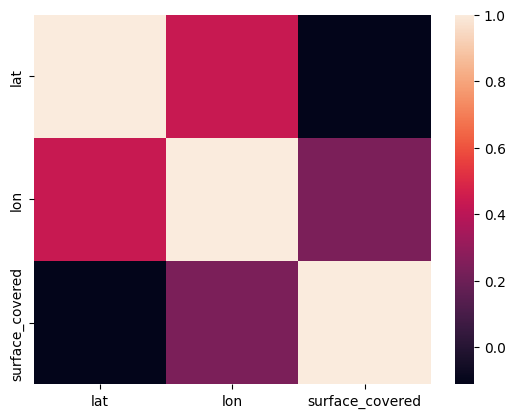

In [10]:
sns.heatmap(corr)

There are no strong correlation between variables.

## Model

First the data is separated in the features X, surfaced covered, lat and lon; and the target y, price.

In [11]:
features = ["surface_covered","lat","lon","neighborhood"]
X = dfs[features]
X.shape

(4032, 4)

In [12]:
target = "price"
y = dfs[target]
y.shape

(4032,)

Then the X and y is split in X train, y train and X test and y test.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Build the model

First the Baseline is calculated.

In [14]:
y_mean=y_train.mean()

In [15]:
y_pred_baseline=[y_mean]*len(y_train)

Now it is calculated the mean absolute error of the baseline.

In [16]:
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)

print("Baseline MAE:", round(mae_baseline, 2))

Baseline MAE: 329417994.38


## Iterate

We make a pipeline with a One Hot Encoder, a Simple Imputer and Ridge.

In [17]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

We fit the model

In [18]:
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

First we predict with the X train.

In [19]:
y_pred_training=model.predict(X_train)

It is calculated the mean absolute error of training.

In [20]:
mae_training=mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 145976773.11


In [21]:
mae_baseline-mae_training

183441221.2670945

We can see the model beats the baseline in 183441221.

Finally, we evaluate the model with the test data.

In [22]:
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    2.475883e+08
1    6.613808e+08
2    5.903085e+08
3    8.660955e+08
4    1.086446e+09
dtype: float64

It is calculated the mean absolute error of test data.

In [23]:
mae_test=mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", round(mae_test, 2))

Test MAE: 155533714.88


## Communicate Results

Finally, the results are communicated. We make a function that can be used to make prediction using the data that the user have.

In [24]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [25]:
make_prediction(57, 4.69, -74.03, "Usaquén")

'Predicted apartment price: $286456336.14'